Some methods require the map density to normalize to one (be on the simplex). This is not as trivial as it may seem. Exactly how this is done can affect downstream applications. This documentation acts as an appendix for these considerations

Map density map be arbitrarily scaled by an additive and multiplicative global constants:
$$
V_{ab} = aV + b \\
a,b \in \mathbb{R}
$$

In [55]:
import torch
import matplotlib.pyplot as plt
import pandas as pd

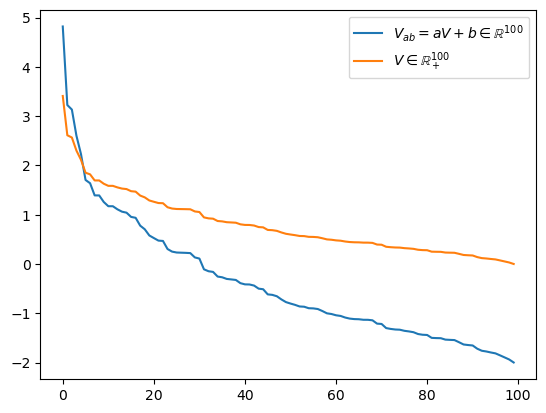

In [57]:
n_voxels = 100
torch.manual_seed(0)
v = torch.randn(n_voxels)
v = torch.abs(v)
v = torch.sort(v, descending=True).values
a = 2
b = -2
vab = a * v + b
plt.plot(vab, label=r"$V_{ab} = aV + b \in \mathbb{R}^{100}$")
plt.plot(v, label=r"$V \in \mathbb{R}_+^{100}$")
plt.legend()

We can normalize by shifting the minimum to zero, and dividing by the total intensity (now all positive), and this gives the same result

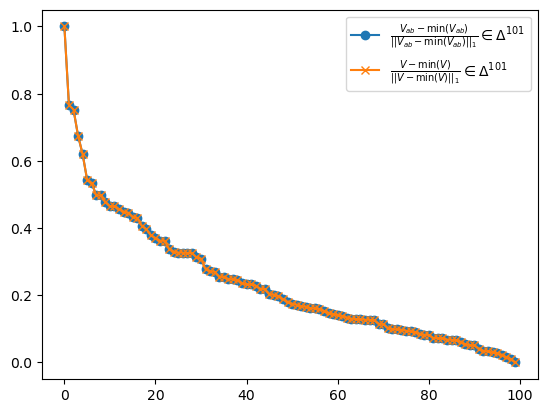

In [58]:
from cryo_challenge._map_to_map.map_to_map_distance import scale_and_sum_normalization

v_normed = scale_and_sum_normalization(v)
vab_normed = scale_and_sum_normalization(vab)
plt.plot(
    vab_normed,
    label=r"$\frac{V_{ab} - \min(V_{ab})}{||V_{ab} - \min(V_{ab})||_1}  \in \Delta^{101}$",
    marker="o",
)
plt.plot(
    v_normed,
    label=r"$\frac{V - \min(V)}{||V - \min(V)||_1}  \in \Delta^{101}$",
    marker="x",
)
plt.legend()
plt.show()

However, what happens when we have an outlier (in inteisty)?

While the unnormalized distrubiton is very similar, the noramlized values have a rather different scaling. 

This indicates that the normalization is not robust to outliers.

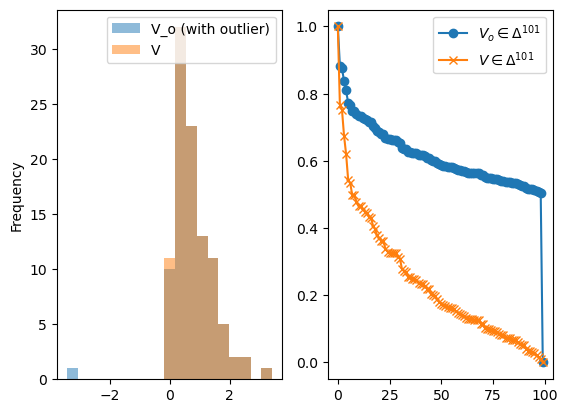

In [59]:
vo = v.clone()
vo[-1] = vo.min() - (vo.max() - vo.min())

n_voxels = 10


bin_min = min(v.min(), vo.min())
bin_max = max(v.max(), vo.max())
bins = torch.linspace(bin_min, bin_max, 20)

fig, axes = plt.subplots(1, 2)

pd.Series(vo).plot.hist(ax=axes[0], alpha=0.5, bins=bins, label="V_o (with outlier)")
pd.Series(v).plot.hist(ax=axes[0], alpha=0.5, bins=bins, label="V")
axes[0].legend()

v_normed = scale_and_sum_normalization(v)
vp_normed = scale_and_sum_normalization(vo)
axes[1].plot(vp_normed, label=r"$V_o  \in \Delta^{101}$", marker="o")
axes[1].plot(v_normed, label=r"$V  \in \Delta^{101}$", marker="x")
axes[1].legend()

We could quantify how far the normalizations are from each other by taking a Euclindean norm. This value is rather large. Could we pick another normalization that minimized it? Conversely, if we wanted to minimize it, what algorithm would do this?

Ref [1] derivates an algorithm that solves the following problem

$$
\min_{V^\prime \in \Delta^{n+1}} ||V^\prime-V||^2_2
$$

[1] Wang, W., & Carreira-Perpiñán, M. Á. (2013). Projection onto the probability simplex: An efficient algorithm with a simple proof, and an application, (2008), 1–5.

In [60]:
import torch


def euclidean_projection_simplex(y: torch.Tensor) -> torch.Tensor:
    """
    Projects a vector y onto the probability simplex.

    Args:
        y (torch.Tensor): Input tensor of shape (D,)

    Returns:
        torch.Tensor: Projected tensor onto the probability simplex
    """
    D = y.shape[0]
    u, _ = torch.sort(y, descending=True)
    cumsum_u = torch.cumsum(u, dim=0)

    rho = torch.nonzero(
        u + (1 / (torch.arange(1, D + 1, device=y.device))) * (1 - cumsum_u) > 0,
        as_tuple=True,
    )[0].max()
    lambda_ = (1 - cumsum_u[rho]) / (rho + 1)

    return torch.maximum(y + lambda_, torch.tensor(0.0, device=y.device))


veps = euclidean_projection_simplex(v)
vabeps = euclidean_projection_simplex(vab)
voeps = euclidean_projection_simplex(vo)

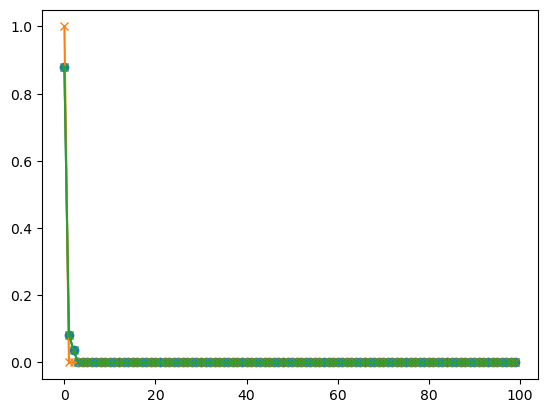

In [61]:
plt.plot(veps, label=r"$V_o  \in \Delta^{101}$", marker="o")
plt.plot(vabeps, label=r"$V  \in \Delta^{101}$", marker="x")
plt.plot(voeps, label=r"$V  \in \Delta^{101}$", marker="x")

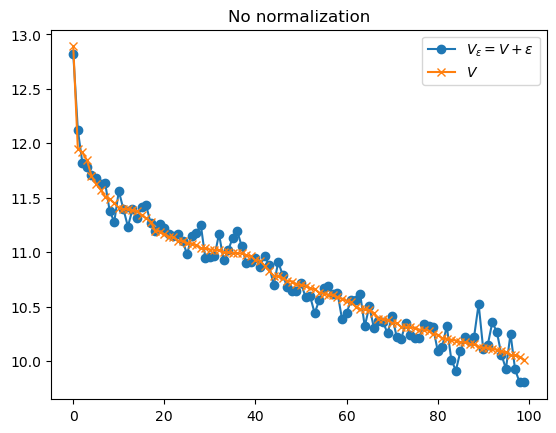

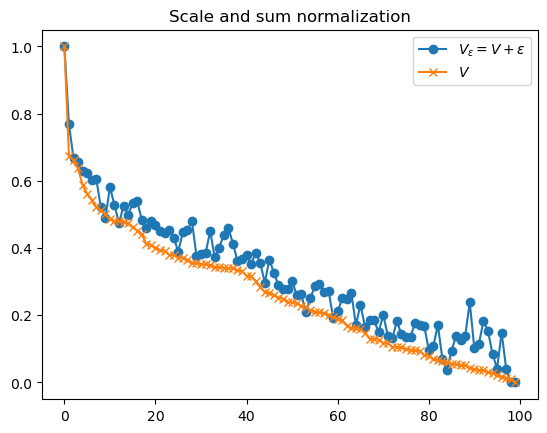

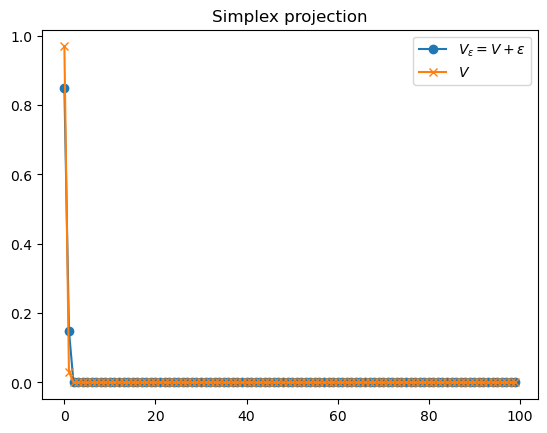

In [62]:
n_voxels = 100
v = torch.randn(n_voxels)
v = torch.abs(v)
v = torch.sort(v, descending=True).values + 10

noise = torch.randn(n_voxels) * 0.1
vn = v + noise
plt.plot(vn, label=r"$V_{\epsilon} = V + \epsilon$", marker="o")
plt.plot(v, label=r"$V$", marker="x")
plt.legend()
plt.title("No normalization")
plt.show()

plt.plot(
    scale_and_sum_normalization(vn), label=r"$V_{\epsilon} = V + \epsilon$", marker="o"
)
plt.plot(scale_and_sum_normalization(v), label=r"$V$", marker="x")
plt.title("Scale and sum normalization")
plt.legend()
plt.show()


plt.plot(
    euclidean_projection_simplex(vn), label=r"$V_{\epsilon} = V + \epsilon$", marker="o"
)
plt.plot(euclidean_projection_simplex(v), label=r"$V$", marker="x")
plt.title("Simplex projection")
plt.legend()
plt.show()

In [63]:
from cryo_challenge._map_to_map.map_to_map_distance import vectorized_simplex_projection

Y = torch.stack([v, vn])
X = vectorized_simplex_projection(Y)
assert torch.allclose(euclidean_projection_simplex(v), X[0])
assert torch.allclose(euclidean_projection_simplex(vn), X[1])

# Performance on volumes

In [22]:
fname = "/mnt/home/smbp/ceph/smbpchallenge/round2/set2/processed_submissions/submission_23.pt"
submission = torch.load(fname, weights_only=False)

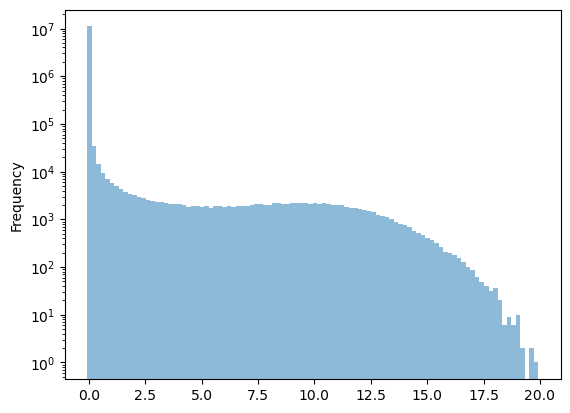

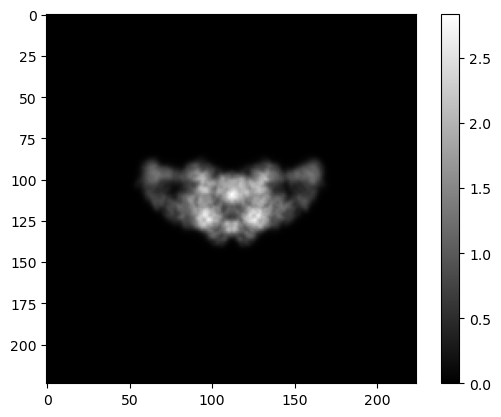

In [67]:
idx = 0
maps = submission["volumes"]
pd.Series(maps[idx].flatten()).plot.hist(bins=100, alpha=0.5, label="V", logy=True)
plt.show()
plt.imshow(maps[idx].mean(2), cmap="gray")
plt.colorbar()

In [4]:
from cryo_challenge._map_to_map.map_to_map_distance import normalize

In [68]:
n = 3
maps_scale_and_sum = normalize(
    maps[:n].clone().reshape(n, -1), method="scale_and_sum"
).reshape(submission["volumes"][:n].shape)

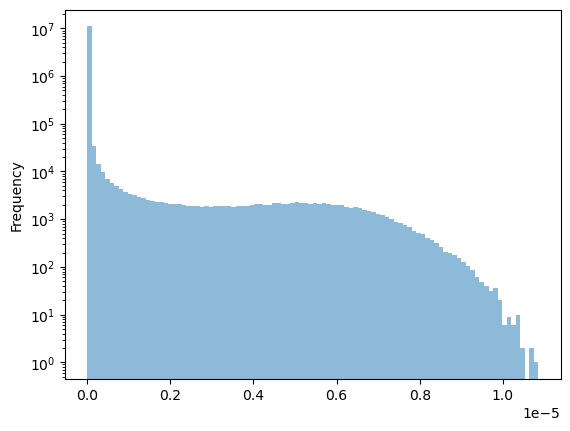

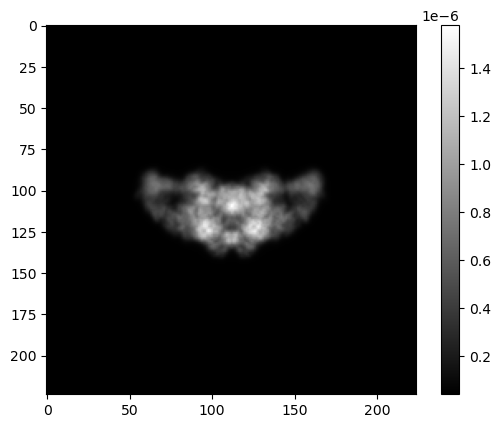

In [69]:
idx = 0

pd.Series(maps_scale_and_sum[idx].flatten()).plot.hist(
    bins=100, alpha=0.5, label="V", logy=True
)
plt.show()
plt.imshow(maps_scale_and_sum[idx].mean(2), cmap="gray")
plt.colorbar()

In [70]:
additive_offset = 1
maps_simplex_projection = normalize(
    maps_scale_and_sum.clone() + additive_offset, method="simplex_projection"
)

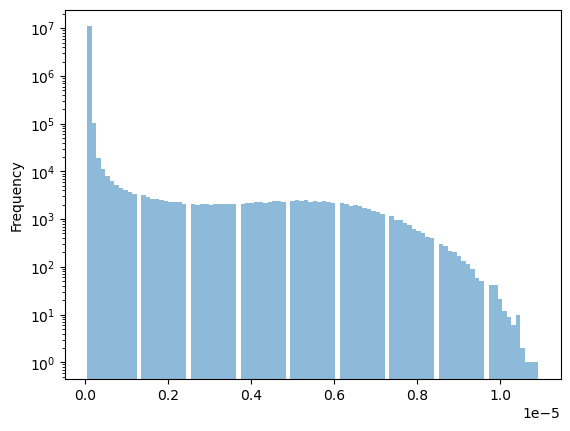

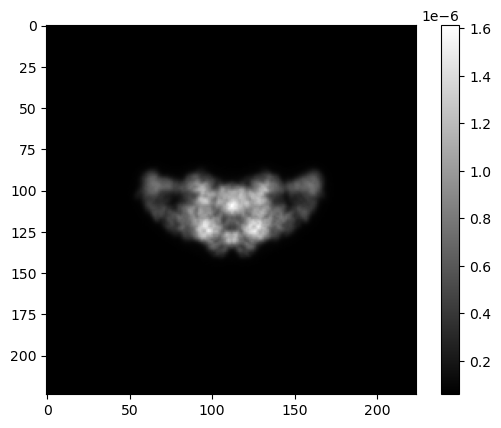

In [71]:
pd.Series(maps_simplex_projection[idx].flatten()).plot.hist(
    bins=100, alpha=0.5, label="V", logy=True
)
plt.show()
plt.imshow(maps_simplex_projection[idx].mean(2), cmap="gray")
plt.colorbar()